In [998]:
import os
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot

# integrate plots into the notebook
%matplotlib inline

In [999]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.gamma = 0.0
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [1000]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [1001]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [1002]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [1003]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [1004]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty(A_source.shape[0]+1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

In [1005]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [1006]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[-1].beta) )
    return b

In [1007]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [1008]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = numpy.empty((panels.size, panels.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -numpy.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [1009]:
def wing(N,r,epsilon_x,epsilon_y,plot):
    
    theta = numpy.linspace(0,(2-(2/N))*numpy.pi,N)
    epsilon = -1*epsilon_x + 1j*epsilon_y
    r_eps = numpy.sqrt(epsilon_x**2+epsilon_y**2)

    z = r*numpy.exp(theta*1j)
    z = z + epsilon
    z = z + r_eps*numpy.exp(theta*1j)
    zeta = z+r**2/z
    x,y = zeta.real, zeta.imag
    if(plot):
        size = 20*r
        x_start, x_end = -2.5, 2.5
        y_start, y_end = -1.5, 1.5
        pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
        pyplot.grid()
        pyplot.xlabel('x', fontsize=16)
        pyplot.ylabel('y', fontsize=16)
        pyplot.xlim(x_start, x_end)
        pyplot.ylim(y_start, y_end)
        pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
    
    return x,y


In [1010]:
def panelize(x,y,alpha,plot):
    N = len(x)-1
    panels = numpy.empty(N, dtype = object)
    for i in range(N):
        panels[i] = Panel(x[i],y[i],x[i+1],y[i+1])
        
    freestream = Freestream(u_inf=1.0, alpha=alpha)
    
    A_source = source_contribution_normal(panels)
    B_vortex = vortex_contribution_normal(panels)
    
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels, freestream)
    
    # solve for singularity strengths
    strengths = numpy.linalg.solve(A, b)

    # store source strength on each panel
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]

    # store circulation density
    gamma = strengths[-1]
    
    compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
    
    compute_pressure_coefficient(panels, freestream)
    
    if(plot):
        pyplot.figure(figsize=(10, 6))
        pyplot.grid()
        pyplot.xlabel('$x$', fontsize=16)
        pyplot.ylabel('$C_p$', fontsize=16)
        pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
                    [panel.cp for panel in panels if panel.loc == 'upper'],
                    label='upper surface',
                    color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
        pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
                    [panel.cp for panel in panels if panel.loc == 'lower'],
                    label= 'lower surface',
                    color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
        pyplot.legend(loc='best', prop={'size':16})
        pyplot.xlim(-2.5, 2.5)
        pyplot.ylim(1.5, -2.0)
        pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);
    
    c = abs(max(panel.xa for panel in panels)
            - min(panel.xa for panel in panels))
    cl = (gamma*sum(panel.length for panel in panels)
          / (0.5*freestream.u_inf*c))

        
    return panels,cl,strengths

In [1011]:
if(False):
    N = 100
    n = 100
    r = 1
    theta = numpy.linspace(0,(2-(2/N))*numpy.pi,N)
    radius = numpy.linspace(r, 3,n)
    R, Theta = numpy.meshgrid(radius,theta)

    epsilon_x = 0.08
    epsilon_y = 0.08

    epsilon = -1*epsilon_x + 1j*epsilon_y
    r_eps = numpy.sqrt(epsilon_x**2+epsilon_y**2)

    z = R*numpy.exp(Theta*1j)
    z = z + epsilon
    z = z + r_eps*numpy.exp(Theta*1j)
    zeta = z+r**2/z
    x,y = zeta[:,0].real, zeta[:,0].imag

In [1012]:
if(False):
    size = 20
    x_start, x_end = -2.5, 2.5
    y_start, y_end = -1.5, 1.5
    pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
    pyplot.grid()
    pyplot.xlabel('x', fontsize=16)
    pyplot.ylabel('y', fontsize=16)
    pyplot.xlim(x_start, x_end)
    pyplot.ylim(y_start, y_end)
    pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)

In [1013]:
if(False):
    N = len(x)-1
    panels = numpy.empty(N, dtype = object)
    for i in range(N):
        panels[i] = Panel(x[i],y[i],x[i+1],y[i+1])

In [1014]:
if(False):
    width = 10
    pyplot.figure(figsize=(width, width))
    pyplot.grid()
    pyplot.xlabel('x', fontsize=16)
    pyplot.ylabel('y', fontsize=16)
    pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
    pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
                numpy.append([panel.ya for panel in panels], panels[0].ya),
                linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
    pyplot.axis('scaled', adjustable='box')
    pyplot.xlim(-2.5,2.5)
    pyplot.ylim(-1, 1);

In [1015]:
if(False):
    aoa = 12
    freestream = Freestream(u_inf=1.0, alpha=aoa)
    A_source = source_contribution_normal(panels)
    B_vortex = vortex_contribution_normal(panels)
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels, freestream)
    # solve for singularity strengths
    strengths = numpy.linalg.solve(A, b)

    # store source strength on each panel
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]

    # store circulation density
    gamma = strengths[-1]
    compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)

In [1016]:
if(False):
    pyplot.figure(figsize=(10, 6))
    pyplot.grid()
    pyplot.xlabel('$x$', fontsize=16)
    pyplot.ylabel('$C_p$', fontsize=16)
    pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
                [panel.cp for panel in panels if panel.loc == 'upper'],
                label='upper surface',
                color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
    pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
                [panel.cp for panel in panels if panel.loc == 'lower'],
                label= 'lower surface',
                color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
    pyplot.legend(loc='best', prop={'size':16})
    pyplot.xlim(-2.5, 2.5)
    pyplot.ylim(1.5, -7.0)
    pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);

In [1017]:
if(False):
    c = abs(max(panel.xa for panel in panels)
            - min(panel.xa for panel in panels))
    cl = (gamma*sum(panel.length for panel in panels)
          / (0.5*freestream.u_inf*c))
    print('lift coefficient: CL = {:0.3f}'.format(cl))

In [1018]:
if(False):
    epsilon_y = 0.08
    alpha = aoa
    x,y = wing(180,1,0.08,epsilon_y,False)
    panels_fun,cl,strengths = panelize(x,y,alpha,False)
    print('Epsilon on y is ',epsilon_y,', lift coefficient: CL = {:0.3f}'.format(cl))

    pyplot.figure(figsize=(10, 6))
    pyplot.grid()
    pyplot.xlabel('$x$', fontsize=16)
    pyplot.ylabel('$C_p$', fontsize=16)
    pyplot.plot([panel.xc for panel in panels_fun if panel.loc == 'upper'],
                [panel.cp for panel in panels_fun if panel.loc == 'upper'],
                label='upper surface',
                color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
    pyplot.plot([panel.xc for panel in panels_fun if panel.loc == 'lower'],
                [panel.cp for panel in panels_fun if panel.loc == 'lower'],
                label= 'lower surface',
                color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
    pyplot.legend(loc='best', prop={'size':16})
    pyplot.xlim(-2.5, 2.5)
    pyplot.ylim(1.5, -7.0)
    pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);


In [1019]:
def cre_panel(alpha,epsilon_y):
    #epsilon_y = 0.08
    #alpha =5
    x,y = wing(180,1,0.08,epsilon_y,False)
    panels_fun,cl,strengths = panelize(x,y,alpha,False)
    
    return panels_fun,x,y

In [1020]:
def trsition(panels_fun):
    # find the control point on the geometry just after the stagnation point
    I = 0
    for i in range(len(panels_fun)):
        if (panels_fun[i].vt/panels_fun[0].vt<0.) :
            I = i
            break

    # control point before stagnation point on upper side
    V1,x1,y1 = panels_fun[I-1].vt,panels_fun[I-1].xc,panels_fun[I-1].yc
    V2,x2,y2 = panels_fun[I].vt,panels_fun[I].xc,panels_fun[I].yc

    # interpolation to find the location of the stagnation point
    xStagn,yStagn = x1-V1*(x2-x1)/(V2-V1) , y1-V1*(y2-y1)/(V2-V1)

    sUpper,VeUpper = numpy.zeros(I+1),numpy.zeros(I+1)

    sUpper[1] = numpy.sqrt((xStagn-panels_fun[I-1].xc)**2+(yStagn-panels_fun[I-1].yc)**2)
    VeUpper[1] = -panels_fun[I-1].vt


    for i in range(1,I):
        sUpper[i+1] = sUpper[i] + panels_fun[I-1-i].length/2
        VeUpper[i+1] = -panels_fun[I-1-i].vt



    rho = 1.2                   # density of air kg/m**3
    mu = 1.9*10**-5             # dynamic viscosity of air kg/ms
    nu = mu/rho                 # kinematic viscosity

    thetaUpper = numpy.zeros(len(sUpper),dtype=float)


    # computing the first value at the stagnation point
    thetaUpper[0] = numpy.sqrt(0.75*nu/abs((VeUpper[1]-VeUpper[0])/(sUpper[1]-sUpper[0])))


    # integration using the trapezoidal rule: Numpy function np.trapz
    for i in range(1,len(thetaUpper)):
        thetaUpper[i] = numpy.sqrt(0.45*nu/VeUpper[i]**6*numpy.trapz(VeUpper[0:i+1]**5,sUpper[0:i+1]))


    dVedsUpper = numpy.zeros(len(VeUpper),dtype=float)

    # defining fucntion to calculate derivative
    def gradient(y,x):
        return numpy.gradient(y,numpy.append(x[1]-x[0],x[1:len(x)]-x[0:len(x)-1]))

    # calculating the gradient of velocity
    dVedsUpper = gradient(VeUpper,sUpper)



    # calculating the pressure gradient parameter           
    lambdaUpper = numpy.zeros(len(sUpper),dtype=float)

    for i in range(len(lambdaUpper)):
        lambdaUpper[i] = ((rho*thetaUpper[i]**2)/mu)*(dVedsUpper[i])



    # calculating the shape factor from lambda
    HUpper = numpy.zeros(len(sUpper),dtype=float)


    for i in range(len(HUpper)):
        if lambdaUpper[i]>0 and lambdaUpper[i]<0.1:
            HUpper[i] = 2.61-3.75*lambdaUpper[i]+5.24*lambdaUpper[i]**2
        if lambdaUpper[i]>-1 and lambdaUpper[i]<=0:
        #if  lambdaUpper[i]<=0:
            HUpper[i] = 2.088+(0.0731/(lambdaUpper[i]+0.14))




    # calculating the parameter l
    lUpper = numpy.zeros(len(sUpper),dtype=float)

    for i in range(len(sUpper)):
        if lambdaUpper[i]>0 and lambdaUpper[i]<0.1:
            lUpper[i] = 0.22+1.402*lambdaUpper[i] + (0.018*lambdaUpper[i])/\
                        (lambdaUpper[i]+0.107)
        if lambdaUpper[i]>-0.1 and lambdaUpper[i]<=0:
            lUpper[i] = 2.088+(0.0731)/(lambdaUpper[i]+0.14)



    # calculating the coefficient of friction
    cfUpper = numpy.zeros(len(sUpper),dtype=float)

    for i in range(len(sUpper)):
        cfUpper[i] = 2*lUpper[i]*(VeUpper[i]*thetaUpper[i]/nu)


    # the criterion is entirely based on the reynolds numbers computed below
    ReTheta = numpy.zeros_like(VeUpper)
    ReS = numpy.zeros_like(ReTheta)
    mc = numpy.zeros_like(ReS)                         # transition criterion   

    for i in range(1,len(mc)-1):
        ReTheta[i] = (rho*VeUpper[i]*thetaUpper[i])/mu     # Re based on momentum thickness
        ReS[i] = (rho*VeUpper[i]*sUpper[i])/mu             # Re based on position
        mc[i] = 1.174*(1+(22400/ReS[i]))*ReS[i]**0.46      # transition criterion
        if mc[i]<ReTheta[i]:
            TR = I -i
            print('Transition point at: ', sUpper[i],TR)
            
            iTrans = i
            sTrans = sUpper[i]                      # used to overwrite in head's
            thetaTrans = thetaUpper[i]
            HTrans = HUpper[i-1]
            break

    return TR


In [1021]:
def rota(alpha,x,y):
    aoa = alpha*numpy.pi/180

    wing_section = x+1j*y
    wing_section = wing_section * numpy.exp(-aoa*1j)
    x,y = wing_section.real,wing_section.imag
    return x,y

In [1022]:
def plot(x,y,TR):
    
    
    valX,valY = 0.1,0.2
    xmin,xmax = min([p.xa for p in panels_fun]),max([p.xa for p in panels_fun])
    ymin,ymax = 1.5*min([p.ya for p in panels_fun]),5*max([p.ya for p in panels_fun])
    xStart,xEnd = xmin-valX*(xmax-xmin),xmax+valY*(xmax-xmin)
    yStart,yEnd = ymin-valY*(ymax-ymin),ymax+valY*(ymax-ymin)
    size = 20
    pyplot.figure(figsize=(size,(yEnd-yStart)/(xEnd-xStart)*size))
    pyplot.grid(True)
    pyplot.xlabel('x',fontsize=16)
    pyplot.ylabel('y',fontsize=16)
    pyplot.title('Displacement Thickness')
    pyplot.xlim(xStart,xEnd)
    pyplot.ylim(yStart,yEnd)
    pyplot.plot(x,y,'k-',linewidth=2)
    pyplot.scatter(x[TR],y[TR],linewidth=2)
    pyplot.show()  

In [1023]:
def integral_u_source(p_i, X, Y):
    
    def integrand(s): 
        return ( (X-(p_i.xa-numpy.sin(p_i.beta)*s))
               /((X-(p_i.xa-numpy.sin(p_i.beta)*s))**2+(Y-(p_i.ya+numpy.cos(p_i.beta)*s))**2) )
    return integrate.quad(integrand,0.0, p_i.length)[0]


def integral_v_source(p_i, X, Y):
    
    def integrand(s):
        return ( (Y-(p_i.ya+numpy.cos(p_i.beta)*s))
               /((X-(p_i.xa-numpy.sin(p_i.beta)*s))**2 + (Y-(p_i.ya+numpy.cos(p_i.beta)*s))**2) )
    return integrate.quad(integrand,0.0, p_i.length)[0]



def integral_u_vortex(p_i, X, Y):
    
    def integrand(s): 
        return ( (X-(p_i.xa-numpy.cos(p_i.beta)*s))
               /((X-(p_i.xa-numpy.cos(p_i.beta)*s))**2+(Y-(p_i.ya+numpy.sin(p_i.beta)*s))**2) )
    return integrate.quad(integrand,0.0, p_i.length)[0]


def integral_v_vortex(p_i, X, Y):
    
    def integrand(s):
        return ( (Y-(p_i.ya+numpy.sin(p_i.beta)*s))
               /((X-(p_i.xa-numpy.cos(p_i.beta)*s))**2 + (Y-(p_i.ya+numpy.sin(p_i.beta)*s))**2) )
    return integrate.quad(integrand,0.0, p_i.length)[0]


In [1024]:
aoa = 20
panels,X,Y = cre_panel(aoa,0.08)
X_wing,Y_wing = X,Y
TR = trsition(panels)
#X,Y = rota(aoa,X,Y)
#plot(X,Y,TR)
#panels[TR+1].vt

Transition point at:  0.3923826665 76


In [1025]:
I = 0
for i in range(len(panels)):
    if (panels[i].vt/panels[0].vt<0.) :
        I = i
        break
            
panels[I-1].vt, panels[0].vt,I

(-0.06004491562486447, -0.068068741876289529, 110)

In [1026]:
def DW_panel_make(ang):
        
    tr_x = [panels[TR].xb, panels[TR].xb+delt_t*numpy.abs(panels[TR+1].vt)/2 *numpy.cos(ang)]
    tr_y = [panels[TR].yb, panels[TR].yb+delt_t*numpy.abs(panels[TR+1].vt)/2 *numpy.sin(ang)]

    u_te = (numpy.sin(panels[0].beta +0.5*numpy.pi)*-1*panels[0].vt)-(numpy.sin(panels[-1].beta +0.5*numpy.pi)*-1*panels[0].vt)
    v_te = (numpy.cos(panels[0].beta +0.5*numpy.pi)*-1*panels[0].vt)-(numpy.cos(panels[-1].beta +0.5*numpy.pi)*-1*panels[0].vt)

    wa_length = numpy.sqrt(u_te**2 + v_te**2)
    
    n,beta=0,0
    
    for i in range(1):
        beta += panels[-i].beta
        n+=1

    beta = beta / n

    wa_x = [panels[-1].xb, panels[-1].xb - numpy.cos(beta+0.5*numpy.pi) *wa_length*delt_t]
    wa_y = [panels[-1].yb, panels[-1].yb - numpy.sin(beta+0.5*numpy.pi) *wa_length*delt_t]

    DW_panel = numpy.empty(2, dtype = object)
    DW_panel[0] = Panel(wa_x[0],wa_y[0],wa_x[1],wa_y[1])
    DW_panel[1] = Panel(tr_x[0],tr_y[0],tr_x[1],tr_y[1])
        
    return DW_panel

In [1027]:
panels[TR+1].vt

-2.6289829076179823

In [1028]:
ang = aoa*numpy.pi/180.0

In [1098]:
delt_t = 0.2
DW_panel = DW_panel_make(ang)

In [1099]:
ang/numpy.pi*180

13.104244868446406

In [1100]:
u_te = (numpy.sin(panels[0].beta +0.5*numpy.pi)*-1*panels[0].vt)-(numpy.sin(panels[-1].beta +0.5*numpy.pi)*-1*panels[0].vt)

v_te = (numpy.cos(panels[0].beta +0.5*numpy.pi)*-1*panels[0].vt)-(numpy.cos(panels[-1].beta +0.5*numpy.pi)*-1*panels[0].vt)

gamma_w= -numpy.sqrt(u_te**2 + v_te**2)

gamma_s = -panels[TR+1].vt

gamma_w,gamma_s

(-0.98396469656528185, 1.1565004457328905)

In [1101]:
gamma

[3.3294984956811473,
 -1.8522380269366101,
 -0.77505168603373176,
 1.3571954828755937]

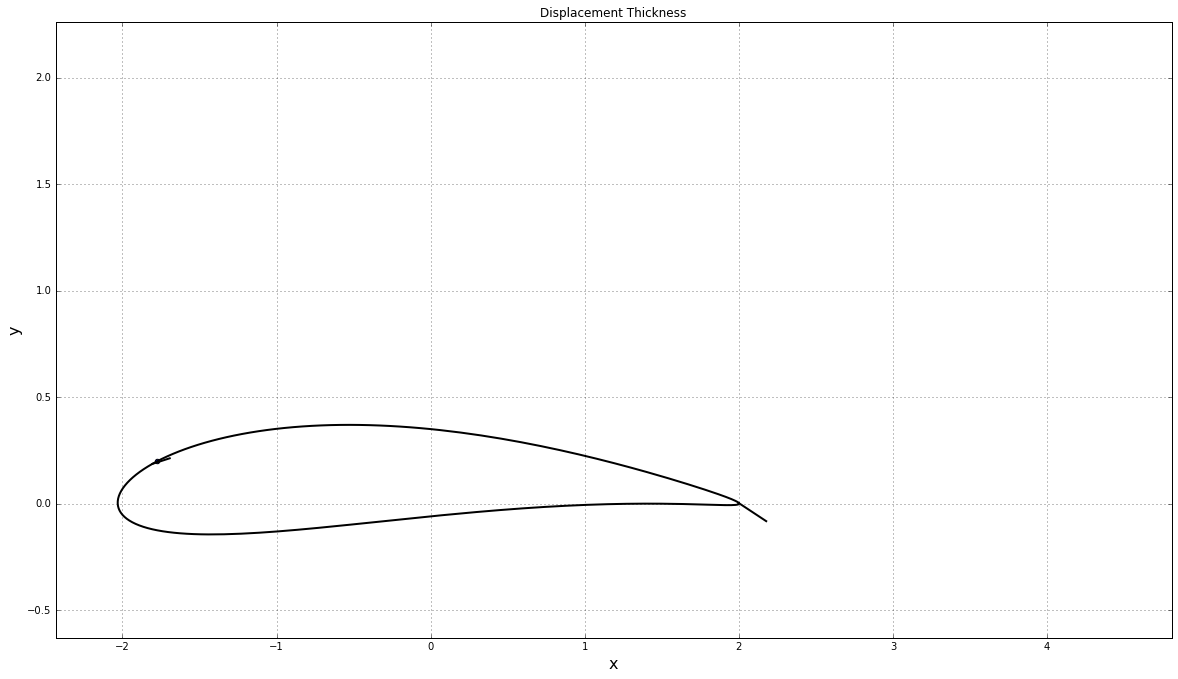

In [1102]:
tr_x,tr_y = [DW_panel[1].xa,DW_panel[1].xb],[DW_panel[1].ya,DW_panel[1].yb]
wa_x,wa_y = [DW_panel[0].xa,DW_panel[0].xb],[DW_panel[0].ya,DW_panel[0].yb]
valX,valY = 0.1,0.2
xmin,xmax = min([p.xa for p in panels_fun]),max([p.xa for p in panels_fun])
ymin,ymax = 1.5*min([p.ya for p in panels_fun]),5*max([p.ya for p in panels_fun])
xStart,xEnd = xmin-valX*(xmax-xmin),xmax+valY*(xmax-xmin)
yStart,yEnd = ymin-valY*(ymax-ymin),ymax+valY*(ymax-ymin)
size = 20
pyplot.figure(figsize=(size,(yEnd-yStart)/(xEnd-xStart)*size))
pyplot.grid(True)
pyplot.xlabel('x',fontsize=16)
pyplot.ylabel('y',fontsize=16)
pyplot.title('Displacement Thickness')
pyplot.xlim(xStart,xEnd+2)
pyplot.ylim(yStart,yEnd)
pyplot.plot(X_wing,Y_wing,'k-',linewidth=2)
pyplot.scatter(X_wing[TR],Y_wing[TR])
pyplot.plot(tr_x,tr_y,'k-',linewidth=2)
pyplot.plot(wa_x,wa_y,'k-',linewidth=2)

In [1056]:
def build_singularity_matrix_wake(A_source, B_vortex,TR):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.zeros((A_source.shape[0]+2, A_source.shape[1]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = numpy.sum(B_vortex, axis=1)  #for gamma1
    A[:-2, -1] = numpy.sum(B_vortex, axis=1)  #for gamma2
    
    for i in range(A_source.shape[0]):
        if(i<=TR):
            A[i, -2] = 0
        else:
            A[i, -1] = 0
    
    #stagnation at trsition point
    length1,length2 = 0,0
    for i, panel_i in enumerate(panels):
        if(i<=TR):
            length2 += panel_i.length
        else:
            length1 += panel_i.length
    
    
    #A[-2, -2] = length1
    #A[-2, -1] = length2
    A[-2, :] = condition_separation(A_source, B_vortex,TR)
    
    # Kutta condition array    
    A[-1, :] = kutta_condition_wake(A_source, B_vortex,TR)
    return A

In [1057]:
def condition_separation(A_source, B_vortex,TR):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty(A_source.shape[0]+2, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-2] = B_vortex[TR, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    
    
    
    b[-2] = - numpy.sum(A_source[TR, TR+1:])
    b[-1] = - numpy.sum(A_source[TR, :TR])
    

            
            
    return b

In [1058]:
def kutta_condition_wake(A_source, B_vortex,TR):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty(A_source.shape[0]+2, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-2] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    
    
    
    b[-2] = - numpy.sum(A_source[0, TR+1:] + A_source[-1, TR+1:])
    b[-1] = - numpy.sum(A_source[0, :TR] + A_source[-1, :TR])
            
            
    return b

In [1059]:
def build_freestream_rhs_wake(panels, freestream,DW_panel,gamma_w,gamma_s,TR):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):

            b[i] =(  -freestream.u_inf *numpy.cos(freestream.alpha - panel.beta)
                   
                     +(gamma_w*0.5/numpy.pi*integral(panel.xc, panel.yc,DW_panel[0],
                                                     numpy.sin(panel.beta),-numpy.cos(panel.beta)))
                   
                     *numpy.cos(numpy.arctan((panel.yc-DW_panel[0].yc)/(panel.yc-DW_panel[0].yc))
                                -0.5*numpy.pi-panel.beta)
                   
                     +(gamma_s*0.5/numpy.pi*integral(panel.xc, panel.yc,DW_panel[1],
                                                     numpy.sin(panel.beta),-numpy.cos(panel.beta)))
                   
                     *numpy.cos(numpy.arctan((panel.yc-DW_panel[1].yc)/(panel.yc-DW_panel[1].yc))
                                -0.5*numpy.pi-panel.beta))
        
    
    if(1):
        b[-2] =( numpy.sin(freestream.alpha - panels[TR].beta)-freestream.u_inf*numpy.sin(freestream.alpha - panels[TR].beta)
                
                 +gamma_w*0.5/numpy.pi*integral(panels[TR].xc, panels[TR].yc,DW_panel[0],
                                                numpy.sin(panels[TR].beta),-numpy.cos(panels[TR].beta))
                
                 *numpy.sin(numpy.arctan((panels[TR].yc-DW_panel[0].yc)/(panels[TR].yc-DW_panel[0].yc))
                            +0.5*numpy.pi-panels[TR].beta)
                
                 +gamma_s*0.5/numpy.pi*integral(panels[TR].xc, panels[TR].yc,DW_panel[1],
                                                numpy.sin(panels[TR].beta),-numpy.cos(panels[TR].beta))
                
                 *numpy.sin(numpy.arctan((panels[TR].yc-DW_panel[1].yc)/(panels[TR].yc-DW_panel[1].yc))
                            +0.5*numpy.pi-panels[TR].beta))     
    
    
    # freestream contribution on the Kutta condition
    b[-1] =( (numpy.sin(freestream.alpha-panels[0].beta)+numpy.sin(freestream.alpha-panels[-1].beta))*(-freestream.u_inf)
            
             +(gamma_w*0.5/numpy.pi*integral(panels[0].xc, panels[0].yc,DW_panel[0],
                                             numpy.sin(panels[0].beta),-numpy.cos(panels[0].beta)))
             *(numpy.sin(numpy.arctan((panels[0].yc-DW_panel[0].yc)/(panels[0].yc-DW_panel[0].yc))+0.5*numpy.pi-panels[0].beta))
            
             +(gamma_w*0.5/numpy.pi*integral(panels[-1].xc, panels[-1].yc,DW_panel[0],
                                             numpy.sin(panels[-1].beta),-numpy.cos(panels[-1].beta)))
             *(numpy.sin(numpy.arctan((panels[-1].yc-DW_panel[0].yc)/(panels[-1].yc-DW_panel[0].yc))+0.5*numpy.pi-panels[-1].beta))
            
             +(gamma_s*0.5/numpy.pi*integral(panels[0].xc, panels[0].yc,DW_panel[1],
                                             numpy.sin(panels[0].beta),-numpy.cos(panels[0].beta)))
             *(numpy.sin(numpy.arctan((panels[0].yc-DW_panel[1].yc)/(panels[0].yc-DW_panel[1].yc))+0.5*numpy.pi-panels[0].beta))
            
             +(gamma_s*0.5/numpy.pi*integral(panels[-1].xc, panels[-1].yc,DW_panel[1],
                                             numpy.sin(panels[-1].beta),-numpy.cos(panels[-1].beta)))
             *(numpy.sin(numpy.arctan((panels[-1].yc-DW_panel[1].yc)/(panels[-1].yc-DW_panel[1].yc))+0.5*numpy.pi-panels[-1].beta)) 
            )
    
    
    
    return b

In [1060]:
def compute_tangential_velocity_wake(panels, freestream, gamma, TR, DW_panel, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = numpy.empty((panels.size, panels.size+4), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-4] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -4] = -numpy.sum(A_source, axis=1)  # for gamma1
    A[:, -3] = -numpy.sum(A_source, axis=1)  # for gamma2
    
    for i in range(panels.size):
        if(i<=TR):
            A[i, -2] = 0
        else:
            A[i, -1] = 0
    
    for i, panel_i in enumerate(panels):
        A[i, -2] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                DW_panel[0],
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
        A[i, -1] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                DW_panel[1],
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [1061]:
freestream = Freestream(u_inf=1.0, alpha=aoa)

In [1062]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [1063]:
A_source.shape,panels.shape

((179, 179), (179,))

In [1064]:
A = build_singularity_matrix_wake(A_source, B_vortex,TR)
b = build_freestream_rhs_wake(panels, freestream,DW_panel,gamma_w,gamma_s,TR)

In [1065]:
# solve for singularity strengths
strengths = numpy.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma1 = strengths[-2]
gamma2 = strengths[-1]
gamma = [gamma1, gamma2, gamma_w, gamma_s]
gamma

[3.3294984956811473,
 -1.8522380269366101,
 -0.77505168603373176,
 1.3571954828755937]

In [1066]:
compute_tangential_velocity_wake(panels, freestream, gamma, TR, DW_panel, A_source, B_vortex)

In [1067]:
compute_pressure_coefficient(panels, freestream)

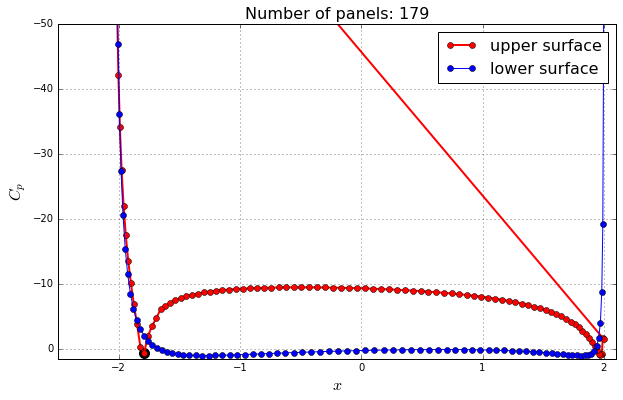

In [1095]:
# plot surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.scatter(panels[TR].xc,panels[TR].cp,color='k', s=100)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-2.5, 2.1)
pyplot.ylim(1.5, -50.0)
pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);

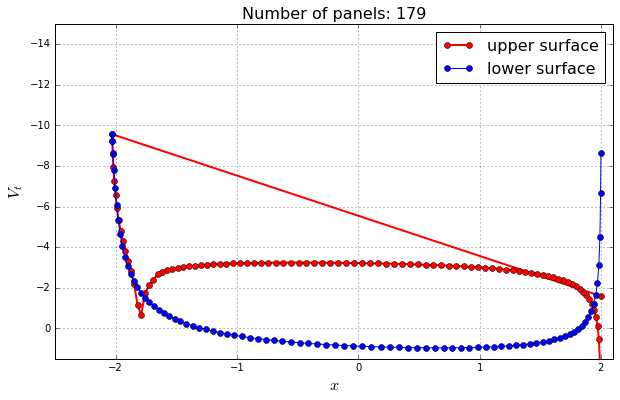

In [1069]:
# plot surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$V_t$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.vt for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.vt for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)

pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-2.5, 2.1)
pyplot.ylim(1.5, -15.0)
pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);

In [1070]:
c = abs(max(panel.xa for panel in panels)
        - min(panel.xa for panel in panels))
cl = (gamma[0]*sum(panel.length for panel in panels[TR+1:]))
+(gamma[1]*sum(panel.length for panel in panels[:TR]))
/(0.5*freestream.u_inf*c)
print('lift coefficient: CL = {:0.3f}'.format(cl))

lift coefficient: CL = 14.626


In [1086]:
def U_m():
    vec_integral_u = numpy.vectorize(integral_u_source)
    vec_integral_v = numpy.vectorize(integral_v_source)

    vec_integral_u1 = numpy.vectorize(integral_u_vortex)
    vec_integral_v1 = numpy.vectorize(integral_v_vortex)

    u_panel_tr,v_panel_tr = 0,0

    for i, p_i in enumerate(panels):  
        u_panel_tr += p_i.sigma*0.5/numpy.pi*vec_integral_u(p_i, DW_panel[1].xc,DW_panel[1].yc)
        v_panel_tr += p_i.sigma*0.5/numpy.pi*vec_integral_v(p_i, DW_panel[1].xc,DW_panel[1].yc)
        if(i<=TR):
            u_panel_tr -= gamma[1]*0.5/numpy.pi*vec_integral_u1(p_i, DW_panel[1].xc,DW_panel[1].yc)
            v_panel_tr -= gamma[1]*0.5/numpy.pi*vec_integral_v1(p_i, DW_panel[1].xc,DW_panel[1].yc)
        else:
            u_panel_tr -= gamma[0]*0.5/numpy.pi*vec_integral_u1(p_i, DW_panel[1].xc,DW_panel[1].yc)
            v_panel_tr -= gamma[0]*0.5/numpy.pi*vec_integral_v1(p_i, DW_panel[1].xc,DW_panel[1].yc)

    u_panel_tr -= gamma[2]*0.5/numpy.pi*vec_integral_u1(DW_panel[0], DW_panel[1].xc,DW_panel[1].yc)
    v_panel_tr -= gamma[2]*0.5/numpy.pi*vec_integral_v1(DW_panel[0], DW_panel[1].xc,DW_panel[1].yc)


    u_m = freestream.u_inf *numpy.cos(freestream.alpha) + u_panel_tr
    v_m = freestream.u_inf *numpy.sin(freestream.alpha) + v_panel_tr

    ang = numpy.arctan((numpy.abs(v_m)+numpy.abs(panels[TR+1].vt*numpy.sin(panels[TR+1].beta+0.5*numpy.pi)))/
                           (numpy.abs(u_m)+numpy.abs(panels[TR+1].vt*numpy.cos(panels[TR+1].beta+0.5*numpy.pi))))

    return ang,u_m,v_m

In [1097]:
ang_pre = 0
error = 10
n = 0
while error>0.01 and n <15 :
    ang,u_m,v_m = U_m()
    DW_panel = DW_panel_make(ang)
    error = numpy.abs(ang - ang_pre)
    ang_pre = ang
    n+=1
    print("Round: ", n , ", result: " , ang/numpy.pi*180)
    
print(u_m,v_m,ang/numpy.pi*180)

Round:  1 , result:  40.411010963
Round:  2 , result:  44.1226190313
Round:  3 , result:  13.1042448684
Round:  4 , result:  27.9621403353
Round:  5 , result:  40.411010963
Round:  6 , result:  44.1226190313
Round:  7 , result:  13.1042448684
Round:  8 , result:  27.9621403353
Round:  9 , result:  40.411010963
Round:  10 , result:  44.1226190313
Round:  11 , result:  13.1042448684
Round:  12 , result:  27.9621403353
Round:  13 , result:  40.411010963
Round:  14 , result:  44.1226190313
Round:  15 , result:  13.1042448684
-1.72621373443 -0.196949006996 13.1042448684


In [ ]:
if(False):
    N = 50
    n = 50
    r = 1
    theta = numpy.linspace(0,2*numpy.pi,N)
    radius = numpy.linspace(r, 3,n)
    R, Theta = numpy.meshgrid(radius,theta)

    epsilon_x = 0.08
    epsilon_y = 0.08

    epsilon = -1*epsilon_x + 1j*epsilon_y
    r_eps = numpy.sqrt(epsilon_x**2+epsilon_y**2)

    z = R*numpy.exp(Theta*1j)
    z = z + epsilon
    z = z + r_eps*numpy.exp(Theta*1j)
    zeta = z+r**2/z
    X,Y = zeta.real, zeta.imag
    X_wing,Y_wing = zeta[:,0].real, zeta[:,0].imag

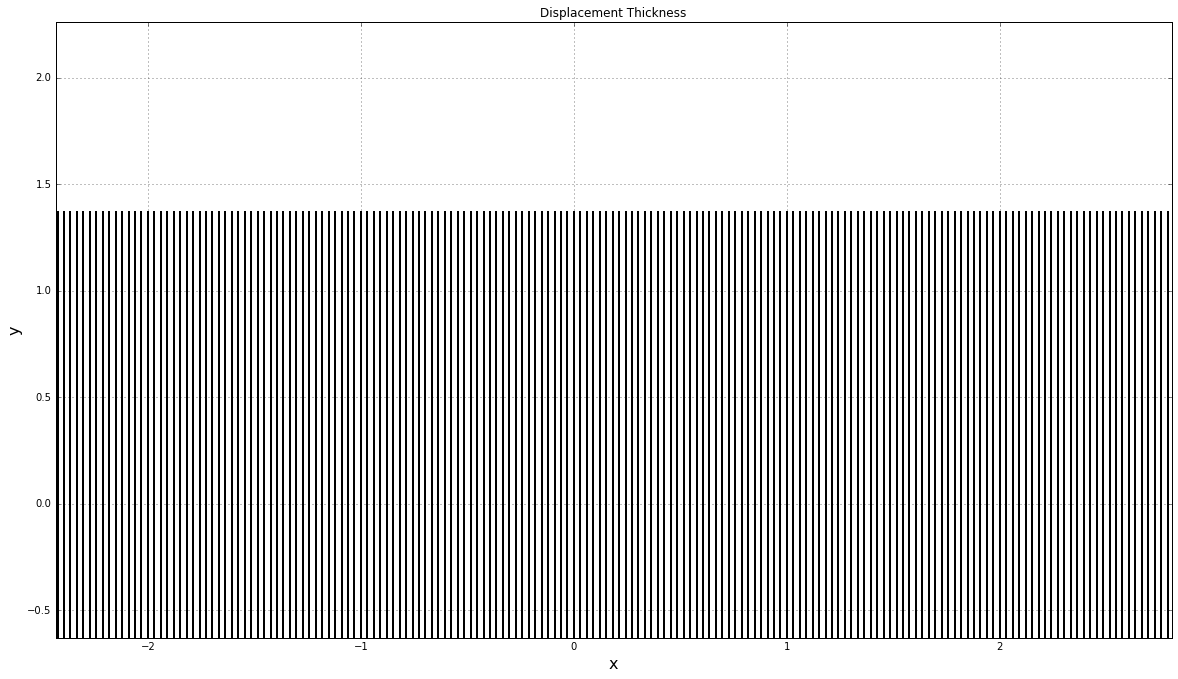

In [292]:
plot(X,Y,20)

In [1075]:
if(True):
    space = 1

    x_start, x_end = numpy.min(X) - space, numpy.max(X) + space
    y_start, y_end = numpy.min(Y) - space, numpy.max(Y) + space

    N = 20

    x = numpy.linspace(x_start,x_end, N)
    y = numpy.linspace(y_start,y_end, N)

    X,Y = numpy.meshgrid(x,y)

In [1076]:
vec_integral_u = numpy.vectorize(integral_u_source)
vec_integral_v = numpy.vectorize(integral_v_source)

vec_integral_u1 = numpy.vectorize(integral_u_vortex)
vec_integral_v1 = numpy.vectorize(integral_v_vortex)

u_panel = numpy.zeros((numpy.shape(X)),dtype=float)
v_panel = numpy.zeros((numpy.shape(Y)),dtype=float)
for i, p_i in enumerate(panels):  
    u_panel += p_i.sigma*0.5/numpy.pi*vec_integral_u(p_i, X,Y)
    v_panel += p_i.sigma*0.5/numpy.pi*vec_integral_v(p_i, X,Y)
    if(i<=TR):
        u_panel -= gamma[1]*0.5/numpy.pi*vec_integral_u1(p_i, X,Y)
        v_panel -= gamma[1]*0.5/numpy.pi*vec_integral_v1(p_i, X,Y)
    else:
        u_panel -= gamma[0]*0.5/numpy.pi*vec_integral_u1(p_i, X,Y)
        v_panel -= gamma[0]*0.5/numpy.pi*vec_integral_v1(p_i, X,Y)
        
u_panel -= gamma[2]*0.5/numpy.pi*vec_integral_u1(DW_panel[0], X,Y)
v_panel -= gamma[2]*0.5/numpy.pi*vec_integral_v1(DW_panel[0], X,Y)

u_panel -= gamma[3]*0.5/numpy.pi*vec_integral_u1(DW_panel[1], X,Y)
v_panel -= gamma[3]*0.5/numpy.pi*vec_integral_v1(DW_panel[1], X,Y)

u = freestream.u_inf *numpy.cos(freestream.alpha) + u_panel
v = freestream.u_inf *numpy.sin(freestream.alpha) + v_panel

In [1077]:
X.size,len(X),u.size,len(u)

(400, 20, 400, 20)

In [1078]:
aoa = 12

#X,Y = rota(-aoa,X,Y)
#tr_x, tr_y = rota(aoa,tr_x, tr_y)
#wa_x, wa_y = rota(aoa,wa_x, wa_y)

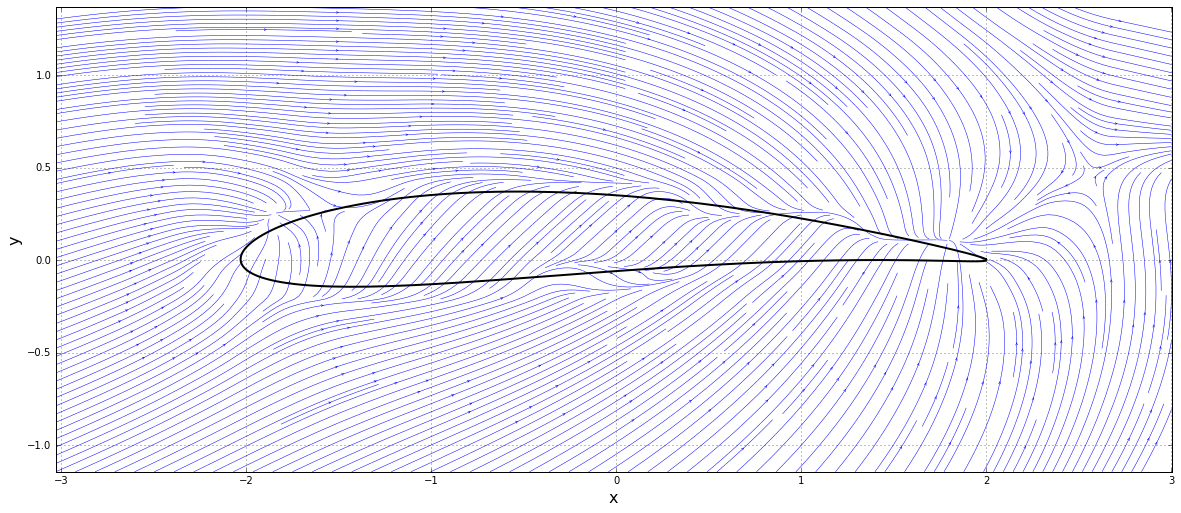

In [1089]:
size = 20
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u, v, density=4, linewidth=0.5, arrowsize=0.5, arrowstyle='->')

pyplot.plot(X_wing, Y_wing, color='k', linestyle='-', linewidth=2)
#pyplot.plot(tr_x, tr_y, color='k', linestyle='-', linewidth=2)
#pyplot.plot(wa_x, wa_y, color='k', linestyle='-', linewidth=2)

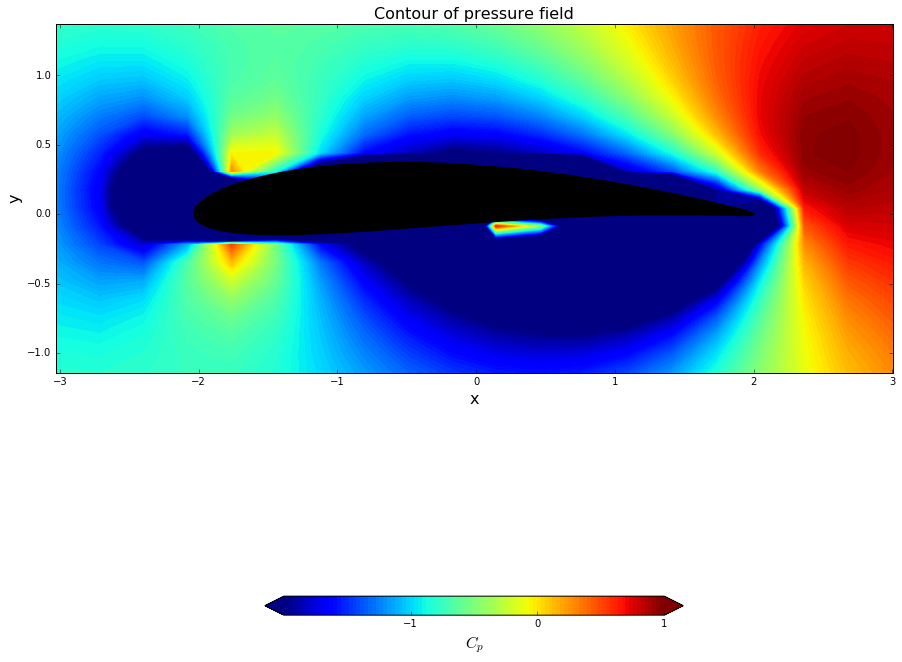

In [1090]:
cp = 1.0 - (u**2+v**2)/freestream.u_inf**2

# plot the pressure field
width = 15
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp,
                        levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.5, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Contour of pressure field', fontsize=16);